# 0. Configuration

In [1]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
RATINGS_SMALL_URL = 'https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link'
MOVIES_METADATA_URL = 'https://drive.google.com/file/d/19g6-apYbZb5D-wRj4L7aYKhxS-fDM4Fb/view?usp=share_link'

# 1. Modules and functions

In [2]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import pandas as pd
import scipy.sparse as sp

from itertools import islice, cycle, product

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
from math import log2

## 1. 1. Helper functions to avoid copy paste

In [3]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given ratings:

In [4]:
# interactions data
interactions = read_csv_from_gdrive(RATINGS_SMALL_URL)
interactions.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [5]:
# information about films etc
movies_metadata = read_csv_from_gdrive(MOVIES_METADATA_URL)
movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [6]:
movies_metadata['id'] = movies_metadata['id'].astype(str)
interactions['movieId'] = interactions['movieId'].astype(str)

In [7]:
# leave only those films that intersect with each other
interactions_filtered = interactions.loc[interactions['movieId'].isin(movies_metadata['id'])]
print(interactions.shape, interactions_filtered.shape)

(100004, 4) (44989, 4)


## 2.2 Data preparation using LightFM Dataset

To use implicit kNN method `fit` we need a sparse matrix in COOrdinate format. To achieve that we will use `scipy.sparse.coo_matrix` from scipy;


In [8]:
def get_coo_matrix(
        df: pd.DataFrame, 
        user_col: str,
        item_col: str, 
        users_mapping: dict, 
        movies_mapping: dict,
        weight_col: str = None
        ):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)
    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            df[user_col].map(users_mapping.get), 
            df[item_col].map(movies_mapping.get)
        )
    ))
    return interaction_matrix


In [9]:
# define users mapping
users_inv_mapping = dict(enumerate(interactions_filtered['userId'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
len(users_mapping)


671

In [10]:
# define movies mapping
movies_inv_mapping = dict(enumerate(interactions_filtered['movieId'].unique()))
movies_mapping = {v: k for k, v in movies_inv_mapping.items()}
len(movies_mapping)


2830

In [11]:
pd.to_datetime(interactions_filtered['timestamp']).unique()

array(['1970-01-01T00:00:01.260759135', '1970-01-01T00:00:01.260759203',
       '1970-01-01T00:00:01.260759139', ...,
       '1970-01-01T00:00:01.064245507', '1970-01-01T00:00:01.064245387',
       '1970-01-01T00:00:01.066793014'], dtype='datetime64[ns]')

<AxesSubplot:>

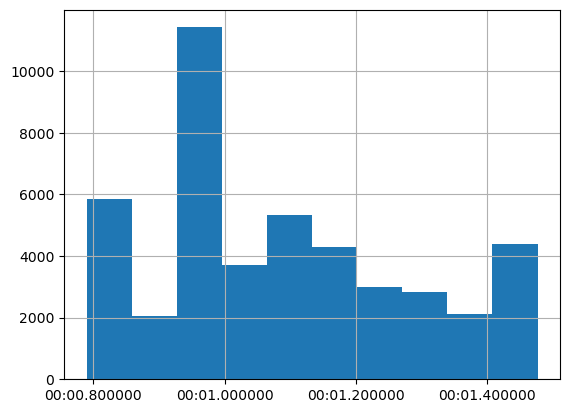

In [12]:
pd.to_datetime(interactions_filtered['timestamp']).hist()

In [20]:
#let's split the data into train and test sets
TRAIN_MAX_DATE = np.quantile([interactions_filtered['timestamp']], 0.75) # define last date to include in train set
TEST_MAX_DATE = interactions_filtered['timestamp'].max()


df=interactions_filtered
interactions_filtered['timestamp'] = pd.to_datetime(interactions_filtered['timestamp'])

train_set = df.loc[df['timestamp'] <= pd.Timestamp(TRAIN_MAX_DATE)].reset_index(drop = True)
test_set = df.loc[(df['timestamp'] > pd.Timestamp(TRAIN_MAX_DATE)) \
                  & (df['timestamp'] <= pd.Timestamp(TEST_MAX_DATE))].reset_index(drop = True)

In [21]:
print('Train set size: {}'.format(train_set.shape))
print('Test set size: {}'.format(test_set.shape))

Train set size: (33742, 4)
Test set size: (11247, 4)


In [22]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat = get_coo_matrix(
    train_set,
    user_col = 'userId',
    item_col = 'movieId',
    users_mapping = users_mapping,
    movies_mapping = movies_mapping
    ).tocsr()


test_mat = get_coo_matrix(
    test_set,
    user_col = 'userId',
    item_col = 'movieId',
    users_mapping = users_mapping,
    movies_mapping = movies_mapping
    ).tocsr()

In [23]:
train_mat

<671x2830 sparse matrix of type '<class 'numpy.float32'>'
	with 33742 stored elements in Compressed Sparse Row format>

In [24]:
test_mat

<664x2826 sparse matrix of type '<class 'numpy.float32'>'
	with 11247 stored elements in Compressed Sparse Row format>

## 2.3. Model Training & Evaluation

In [`implicit`](https://pypi.org/project/implicit/), there are various models and can be groupped into:
- Item-to-Item: KNN based on various similarities - CosineRecommender, BM25Recommender, TFIDFRecommender
- implicit ALS;
- Logistic Matrix Factorization;
- Bayesian Personalized Ranking (BPR)


### 2.3.1. Train Model

In [25]:
from implicit.nearest_neighbours import (
    CosineRecommender,
    BM25Recommender,
    TFIDFRecommender
    )


Note that in item-to-item models we need to provide matrix in the form of item-user by transposing initial COO matrix user-item


In [26]:
# fit the model
cosine_model = CosineRecommender(K = 20)
cosine_model.fit(train_mat.T)


  0%|          | 0/671 [00:00<?, ?it/s]

### 2.3.2. Evaluate the Model

In [27]:
# let's make sense-check
top_N = 10
user_id = interactions_filtered['userId'].iloc[0]
row_id = users_mapping[user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 1, row number in matrix - 0


In [28]:
users_mapping.values

<function dict.values>

In [29]:
# create mapper for movieId and title names
movie_name_mapper = dict(zip(movies_metadata['id'], movies_metadata['original_title']))

In [30]:
recs = cosine_model.recommend(
    row_id,
    test_mat,
    N = top_N,
    filter_already_liked_items = True
    )
recs = pd.DataFrame(recs).T.rename(columns = {0: 'col_id', 1: 'similarity'})
recs['inv_movie_id'] = recs['col_id'].astype(int)
recs['movieId'] = recs['inv_movie_id'].map(movies_inv_mapping.get)
recs['title'] = recs['movieId'].map(movie_name_mapper)
recs


,col_id,similarity,inv_movie_id,movieId,title
0,653.0,0.861587,653,74458,Mere Brother Ki Dulhan
1,129.0,0.844531,129,1994,The Most Dangerous Game
2,579.0,0.816769,579,5956,Joshua
3,460.0,0.776079,460,1895,Star Wars: Episode III - Revenge of the Sith
4,606.0,0.654064,606,8011,Highlander III: The Sorcerer
5,337.0,0.593856,337,170,28 Days Later
6,648.0,0.577499,648,68954,Longitude
7,399.0,0.561442,399,1088,Whale Rider
8,278.0,0.561442,278,1584,School of Rock
9,150.0,0.557086,150,2100,The Last Castle


### 2.3.3. Wrapping up the rec pipeline into function

In [31]:
def lfm_recommend(model, 
                  users_mapping, 
                  test_mat,
                  top_N:int,
                  movies_inv_mapping,
                  movie_name_mapper
                  ):
    rekkos = pd.DataFrame(data = [], columns=['userId', 'similarity', 'movieId', 'title'])
    for key, value in users_mapping.items():
        
        recs= model.recommend(
        value,
        test_mat,
        N = top_N,
        filter_already_liked_items = True
        )
        
        recs = pd.DataFrame(recs).T.rename(columns = {0: 'col_id', 1: 'similarity'})
        recs['userId'] = [key for x in np.ones(len(recs))]
        recs['inv_movie_id'] = recs['col_id'].astype(int)
        recs['movieId'] = recs['inv_movie_id'].map(movies_inv_mapping.get)
        recs['title'] = recs['movieId'].map(movie_name_mapper)
        
        rekkos = pd.concat([rekkos,recs[['userId', 'similarity','movieId','title']]]).reset_index(drop=True)
        
    return rekkos


In [77]:
final_rekkomendations = lfm_recommend(cosine_model, users_mapping, test_mat, 10, movies_inv_mapping, movie_name_mapper )

### 2.3.4. NDCG@10 calculation

In [78]:
def compute_gain(y_value: float, gain_scheme: str) -> float:
    
    gain = {'exp2': 2 ** y_value - 1,
            'const': y_value}

    return float(gain[gain_scheme])

In [79]:
def dcg(y_true: np.array, y_pred: np.array, gain_scheme: str) -> float:
    
    dcg = 0
    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]

    for idx, val in enumerate(y_true_sorted, 1):
        gain = compute_gain(val, gain_scheme)
        dcg += gain / log2(idx + 1)
        
    return dcg

In [80]:
def ndcg(y_true: np.array, ys_pred: np.array, gain_scheme: str = 'const') -> float:
    
    # pred dcg then we calc the same to find max possible
    preds_dcg = dcg(y_true, ys_pred, gain_scheme)
    max_possible_dcg = dcg(y_true, y_true, gain_scheme)

    return preds_dcg / max_possible_dcg

In [81]:
#let's firstly define relevance score for our predictions based on users' interactions
final_rekkomendations['rank'] = final_rekkomendations.groupby('userId')['similarity'].rank(method = 'first', ascending=True)
interactions = interactions.sort_values(by=['userId', 'timestamp'])
interactions = interactions.groupby('userId').head(10)
interactions['rank_true'] = interactions.groupby('userId')['timestamp'].rank(method = 'first', ascending=False)

In [82]:
final_rekkomendations['userId'] = pd.to_numeric(final_rekkomendations['userId'])
final_rekkomendations['movieId'] = pd.to_numeric(final_rekkomendations['movieId'])

In [83]:
interactions['userId'] = pd.to_numeric(interactions['userId'])
interactions['movieId'] = pd.to_numeric(interactions['movieId'])

In [84]:
final_rekkomendations = final_rekkomendations.merge(interactions[['userId','movieId','rank_true']], on=['userId', 'movieId'], how='left')

In [85]:
#filling the empty movies' ids
final_rekkomendations.rank_true = final_rekkomendations.rank_true.fillna(1)

In [108]:
def metrics_calc(dataset, USER_COL):
    rekko_metrics = pd.DataFrame(data=[], columns=['userId', 'ndcg'])
    final_rekkomendations['rank_true'] = final_rekkomendations['rank_true'].astype('int')
    final_rekkomendations['rank'] = final_rekkomendations['rank'].astype('int')
    for key in users_mapping.keys():
        y_pred = np.array(final_rekkomendations[final_rekkomendations['userId'] == key]['rank'].astype('int').to_list())
        y_true = np.array(final_rekkomendations[final_rekkomendations['userId'] == key]['rank_true'].astype('int').to_list())
        ndcg_metric = ndcg(y_true, y_pred, 'exp2')
        rekko_metrics.loc[key] =  [key, ndcg_metric]
    return rekko_metrics

In [109]:
USER_COL = 'userId'

In [110]:
metrics_calc(final_rekkomendations, USER_COL)

,userId,ndcg
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
5,5.0,1.0
...,...,...
667,667.0,1.0
668,668.0,1.0
669,669.0,1.0
670,670.0,1.0


# TODO
- Make train/test split -- train the model appropiately and predict on test set;
- Wrap up in function recommendations - lfm_recommend();
- Calculate `NDCG@10` on test set